In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def sineexponentialdecay_testing():
    # generation of data for testing
    x_axis = np.linspace(0, 100, 100)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 1000)

    mod, params = fitlogic.make_sineexponentialdecay_model()
    print('Parameters of the model', mod.param_names,
          ' with the independet variable', mod.independent_vars)

    params['amplitude'].value = abs(1 + abs(np.random.normal(0,4)))
    params['frequency'].value = abs(0.01 + abs(np.random.normal(0,0.2)))
    params['phase'].value = abs(np.random.normal(0,2*np.pi))
    params['offset'].value = 12 + np.random.normal(0,5)
    params['lifetime'].value = abs(0 + abs(np.random.normal(0,70)))
    print('\n',
          'amplitude', params['amplitude'].value, '\n',
          'frequency', params['frequency'].value, '\n',
          'phase', params['phase'].value, '\n',
          'offset', params['offset'].value, '\n',
          'lifetime', params['lifetime'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 0.5* np.random.normal(size=x_axis.shape))
    data = data_noisy
    offset = np.average(data)

    # level data
    data_level = data - offset

    # perform fourier transform with zeropadding to get higher resolution
    data_level_zeropaded = np.zeros(int(len(data_level) * 2))
    data_level_zeropaded[:len(data_level)] = data_level
    fourier = np.fft.fft(data_level_zeropaded)
    stepsize = x_axis[1] - x_axis[0]  # for frequency axis
    freq = np.fft.fftfreq(data_level_zeropaded.size, stepsize)
    fourier_power = (fourier * fourier.conj()).real

    plt.plot(freq[:int(len(freq) / 2)], fourier_power[:int(len(freq) / 2)], '-or', label='dft')
    plt.xlim(0, 0.5)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    result = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    plt.plot(x_axis, data_noisy, 'o--b', label='noisy data')
    plt.plot(x_nice,mod.eval(x=x_nice, params=params),'-g', label='original')
    print(result.fit_report())
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0, label='initial fit')
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0, label='best fit')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    units = dict()
    units['frequency'] = 'GHz'
    units['phase'] = 'rad'
    units['amplitude']='arb. u.'

Parameters of the model ['amplitude', 'frequency', 'phase', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude 2.400754704672957 
 frequency 0.22695266552240534 
 phase 6.102719907720662 
 offset 18.488285509469627 
 lifetime 45.192505915808226
[[Model]]
    (((Model(amplitude_function) * Model(bare_sine_function)) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 52
    # data points      = 100
    # variables        = 5
    chi-square         = 23.640
    reduced chi-square = 0.249
    Akaike info crit   = -134.221
    Bayesian info crit = -121.195
[[Variables]]
    amplitude:   2.17910129 +/- 0.213992 (9.82%) (init= 2.334064)
    frequency:   0.22588707 +/- 0.000488 (0.22%) (init= 0.2277)
    phase:      -0.17113855 +/- 0.093761 (54.79%) (init= 0)
    beta:        1 (fixed)
    lifetime:    49.9068587 +/- 7.855953 (15.74%) (init= 11.9714)
    offset:      18.4125612 +/- 0.049917 (0.27%) (in

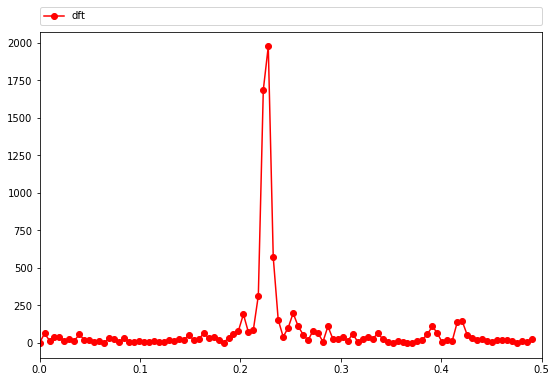

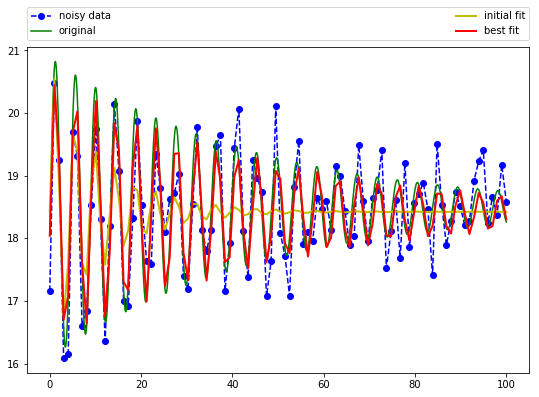

In [3]:
sineexponentialdecay_testing()

In [4]:

def two_sine_exp_decay_offset_testing():
    """ Testing procedure for the implemented two sine with exponential decay
        and offset fit. """

    x_axis = np.linspace(5, 600 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 1
    freq1 = 0.011

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    offset = 1
    lifetime = 100

    data = (ampl1 * np.sin(2*np.pi*freq1*x_axis + phase1)
            + ampl2 * np.sin(2*np.pi*freq2*x_axis + phase2)
           )*np.exp(-(x_axis/lifetime)) + offset
    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*0.6


    result1 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    data_sub = noisy_data - result1.best_fit
    result2 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub,
        estimator=fitlogic.estimate_sineexponentialdecay)

    mod, params = fitlogic.make_sinedoublewithexpdecay_model()

    # Fill the parameter dict:
    params['s1_amplitude'].set(value=result1.params['amplitude'].value)
    params['s1_frequency'].set(value=result1.params['frequency'].value)
    params['s1_phase'].set(value=result1.params['phase'].value)

    params['s2_amplitude'].set(value=result2.params['amplitude'].value)
    params['s2_frequency'].set(value=result2.params['frequency'].value)
    params['s2_phase'].set(value=result2.params['phase'].value)

    lifetime = (result1.params['lifetime'].value + result2.params['lifetime'].value)/2
    params['lifetime'].set(value=lifetime, min=2*(x_axis[1]-x_axis[0]))
    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print("freq1:", result.params['s1_frequency'].value)
    print("freq2:", result.params['s2_frequency'].value)
    print(result.fit_report())

freq1: 0.0100192697905
freq2: 0.0222703283267
[[Model]]
    ((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 200
    # variables        = 8
    chi-square         = 77.679
    reduced chi-square = 0.405
    Akaike info crit   = -173.147
    Bayesian info crit = -146.761
[[Variables]]
    s1_amplitude:   1.31297084 +/- 0.288469 (21.97%) (init= 2.096428)
    s1_frequency:   0.01001926 +/- 0.000372 (3.71%) (init= 0.009999036)
    s1_phase:       5.01646041 +/- 0.218914 (4.36%) (init= 5.040277)
    s2_amplitude:   0.66769065 +/- 0.205709 (30.81%) (init= 0.4869835)
    s2_frequency:   0.02227032 +/- 0.000769 (3.46%) (init= 0.0223232)
    s2_phase:       3.43895459 +/- 0.483615 (14.06%) (init= 3.466913)
    beta:          

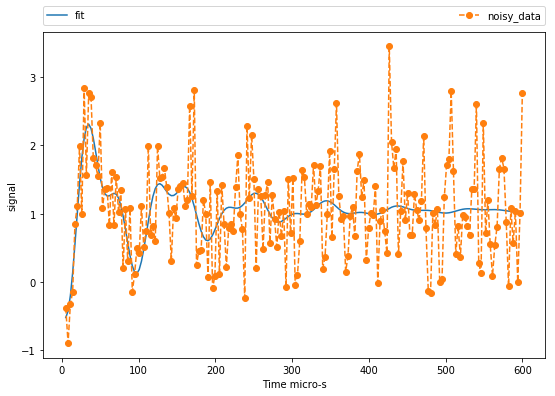

In [5]:
two_sine_exp_decay_offset_testing()

In [6]:
def two_sine_exp_decay_offset_testing2():
    """ Testing procedure for the implemented two sine with offset fit. """

    x_axis = np.linspace(5, 600 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 0.11
    freq1 = 0.02

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 1
    freq2 = 0.01

    offset = 1
    lifetime = 100

    data = (ampl1 * np.sin(2*np.pi*freq1*x_axis + phase1)
            + ampl2 * np.sin(2*np.pi*freq2*x_axis + phase2)
           ) * np.exp(-(x_axis/lifetime)) + offset

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*0.2

    result = fitlogic.make_sinedoublewithexpdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sinedoublewithexpdecay)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    ((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 180
    # data points      = 200
    # variables        = 8
    chi-square         = 8.061
    reduced chi-square = 0.042
    Akaike info crit   = -626.252
    Bayesian info crit = -599.865
[[Variables]]
    s1_amplitude:   0.90182048 +/- 0.100806 (11.18%) (init= 0.9097246)
    s1_frequency:   0.00988885 +/- 0.000210 (2.12%) (init= 0.009888881)
    s1_phase:       4.59096594 +/- 0.115700 (2.52%) (init= 4.591241)
    s2_amplitude:   0.10248133 +/- 0.068336 (66.68%) (init= 1.430575)
    s2_frequency:   0.09018602 +/- 0.001761 (1.95%) (init= 0.08596423)
    s2_phase:       0.14015035 +/- 0.942158 (672.25%) (init= 0.554982)
    beta:           1 (fixed)
    lifetime:       117.923407 +/

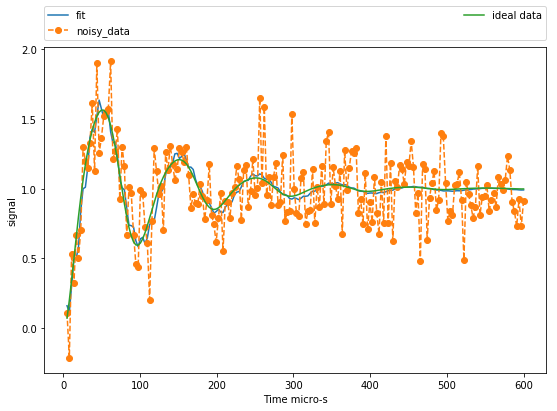

In [7]:
two_sine_exp_decay_offset_testing2()

In [8]:
def two_sine_two_exp_decay_offset_testing():
    """ Testing procedure for the implemented two sine two exponential decay
        with offset fit. """

    x_axis = np.linspace(5, 600 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 1
    freq1 = 0.02

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 3
    freq2 = 0.01

    offset = 1
    lifetime1 = 100
    lifetime2 = 100

    data = (
        ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1)*np.exp(-(x_axis/lifetime1))
        + ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2)*np.exp(-(x_axis/lifetime2))
        + offset)
    
    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*0.5


    result1 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    data_sub = noisy_data - result1.best_fit
    result2 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub,
        estimator=fitlogic.estimate_sineexponentialdecay)

    plt.figure()
    plt.plot(x_axis, data_sub,'-', label='sub')
    plt.plot(x_axis, noisy_data, '-', label='noisy_data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    mod, params = fitlogic.make_sinedoublewithtwoexpdecay_model()

    # Fill the parameter dict:
    params['e1_amplitude'].set(value=result1.params['amplitude'].value)
    params['e1_frequency'].set(value=result1.params['frequency'].value)
    params['e1_phase'].set(value=result1.params['phase'].value)
    params['e1_lifetime'].set(value=result1.params['lifetime'].value, min=2*(x_axis[1]-x_axis[0]))


    params['e2_amplitude'].set(value=result2.params['amplitude'].value)
    params['e2_frequency'].set(value=result2.params['frequency'].value)
    params['e2_phase'].set(value=result2.params['phase'].value)
    params['e2_lifetime'].set(value=result2.params['lifetime'].value, min=2*(x_axis[1]-x_axis[0]))

    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print("freq1:", result.params['e1_frequency'].value)
    print("freq2:", result.params['e2_frequency'].value)

    print(result.fit_report())

freq1: 0.0103871714821
freq2: 0.019289308769
[[Model]]
    ((((Model(amplitude_function, prefix='e1_') * Model(bare_sine_function, prefix='e1_')) * Model(barestretchedexponentialdecay_function, prefix='e1_')) + ((Model(amplitude_function, prefix='e2_') * Model(bare_sine_function, prefix='e2_')) * Model(barestretchedexponentialdecay_function, prefix='e2_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 73
    # data points      = 200
    # variables        = 9
    chi-square         = 48.171
    reduced chi-square = 0.252
    Akaike info crit   = -266.713
    Bayesian info crit = -237.028
[[Variables]]
    e1_amplitude:   3.01465811 +/- 0.326602 (10.83%) (init= 3.435283)
    e1_frequency:   0.01038717 +/- 0.000216 (2.08%) (init= 0.01009247)
    e1_phase:       6.04361541 +/- 0.133654 (2.21%) (init= 6.283185)
    e1_beta:        1 (fixed)
    e1_lifetime:    107.841124 +/- 14.19067 (13.16%) (init= 92.23126)
    e2_amplitude:   1.64542724 +/- 0.501326 (30.47%) (

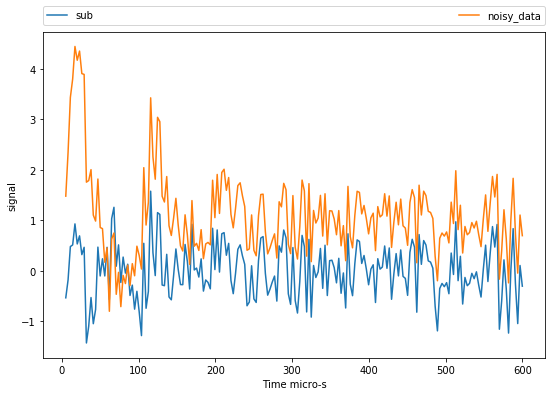

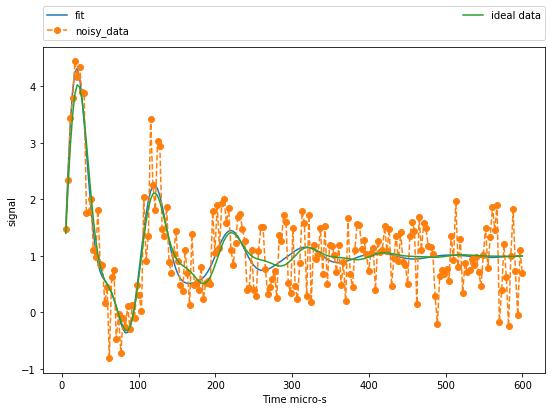

In [9]:
two_sine_two_exp_decay_offset_testing()

In [10]:
def two_sine_two_exp_decay_offset_testing2():
    """ Testing procedure for the implemented two sine with offset fit. """

    x_axis = np.linspace(5, 400 ,200)
    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 2
    freq1 = 0.02

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 1
    freq2 = 0.01

    offset = 1
    lifetime1 = 100
    lifetime2 = 200

    data = (
        ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1) * np.exp(-(x_axis/lifetime1))
        + ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2) * np.exp(-(x_axis/lifetime2))
        + offset)
    
    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*1

    result = fitlogic.make_sinedoublewithtwoexpdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sinedoublewithtwoexpdecay)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    ((((Model(amplitude_function, prefix='e1_') * Model(bare_sine_function, prefix='e1_')) * Model(barestretchedexponentialdecay_function, prefix='e1_')) + ((Model(amplitude_function, prefix='e2_') * Model(bare_sine_function, prefix='e2_')) * Model(barestretchedexponentialdecay_function, prefix='e2_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 63
    # data points      = 200
    # variables        = 9
    chi-square         = 140.057
    reduced chi-square = 0.733
    Akaike info crit   = -53.253
    Bayesian info crit = -23.569
[[Variables]]
    e1_amplitude:   1.67138002 +/- 0.372099 (22.26%) (init= 1.795758)
    e1_frequency:   0.01975169 +/- 0.000363 (1.84%) (init= 0.02003841)
    e1_phase:       2.67961028 +/- 0.204764 (7.64%) (init= 2.499765)
    e1_beta:        1 (fixed)
    e1_lifetime:    123.678367 +/- 36.45260 (29.47%) (init= 112.3138)
    e2_amplitude:   0.68105940 +/- 0.222307 (32.64%) (init= 0.6404976)
    e2_frequency:   0.0095747

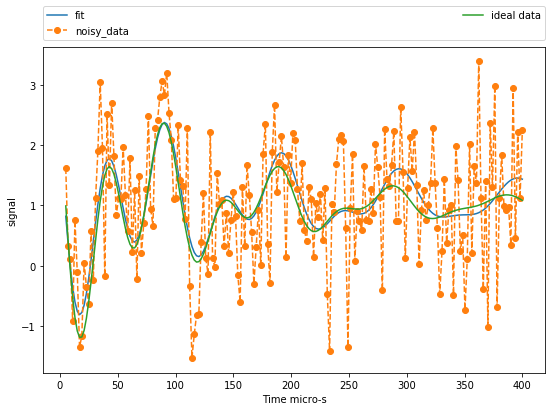

In [11]:
two_sine_two_exp_decay_offset_testing2()

In [12]:
def three_sine_exp_decay_offset_testing():
    """ Testing procedure for the estimator for a three sine with exponential
        decay and with offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 1
    freq3 = 0.05

    lifetime = 100
    offset = 1.1

    data = (
        ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1)
        + ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2)
        + ampl3 * np.sin(2*np.pi*freq3*x_axis +phase3))*np.exp(-(x_axis/lifetime)) + offset

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape) * 1

    x_dft1, y_dft1 = compute_dft(x_val=x_axis, y_val=noisy_data, zeropad_num=1)

    plt.figure()
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time (micro-s)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    res1 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    
    data_sub1 = noisy_data - res1.best_fit
    x_dft2, y_dft2 = compute_dft(x_val=x_axis, y_val=data_sub1, zeropad_num=1)

    res2 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub1,
        estimator=fitlogic.estimate_sineexponentialdecay)

    data_sub2 = data_sub1 - res2.best_fit
    res3 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub2,
        estimator=fitlogic.estimate_sineexponentialdecay)

    x_dft3, y_dft3 = compute_dft(x_val=x_axis, y_val=data_sub2, zeropad_num=1)

    plt.figure()
    plt.plot(x_dft1, y_dft1, '-', label='noisy_data (3 peaks)')
    plt.plot(x_dft2, y_dft2, '-', label='noisy_data (2 peaks)')
    plt.plot(x_dft3, y_dft3, '-', label='noisy_data (1 peak)')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    mod, params = fitlogic.make_sinetriplewithexpdecay_model()

    params['s1_amplitude'].set(value=res1.params['amplitude'].value)
    params['s1_frequency'].set(value=res1.params['frequency'].value)
    params['s1_phase'].set(value=res1.params['phase'].value)

    params['s2_amplitude'].set(value=res2.params['amplitude'].value)
    params['s2_frequency'].set(value=res2.params['frequency'].value)
    params['s2_phase'].set(value=res2.params['phase'].value)

    params['s3_amplitude'].set(value=res3.params['amplitude'].value)
    params['s3_frequency'].set(value=res3.params['frequency'].value)
    params['s3_phase'].set(value=res3.params['phase'].value)

    lifetime = (
        res1.params['lifetime'].value
        + res2.params['lifetime'].value
        + res3.params['lifetime'].value)/3
    
    params['lifetime'].set(value=lifetime, min=2*(x_axis[1]-x_axis[0]))
    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + (Model(amplitude_function, prefix='s3_') * Model(bare_sine_function, prefix='s3_'))) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 135
    # data points      = 200
    # variables        = 11
    chi-square         = 246.518
    reduced chi-square = 1.304
    Akaike info crit   = 63.823
    Bayesian info crit = 100.105
[[Variables]]
    s1_amplitude:   2.78833670 +/- 0.383932 (13.77%) (init= 3.816717)
    s1_frequency:   0.03011880 +/- 0.000349 (1.16%) (init= 0.02891432)
    s1_phase:       3.71751542 +/- 0.171309 (4.61%) (init= 4.221084)
    s2_amplitude:   2.23454878 +/- 0.337292 (15.09%) (init= 1.611315)
    s2_frequency:   0.01029953 +/- 0.000471 (4.57%) (init= 0.01056528)
    s2_phase:       0.54405608 +/- 0.246973 (45.

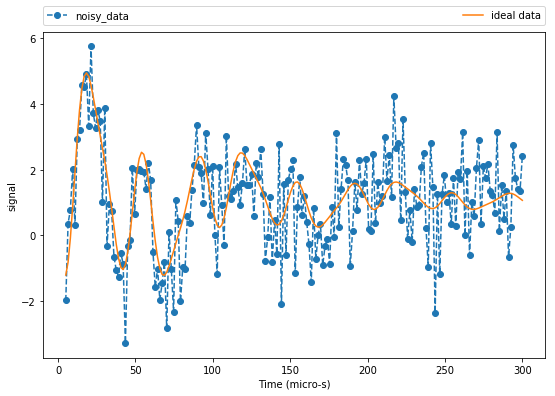

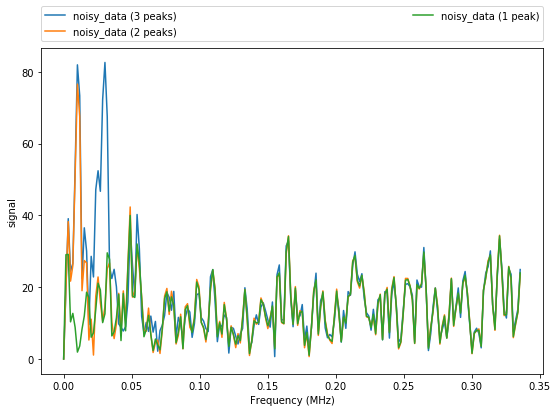

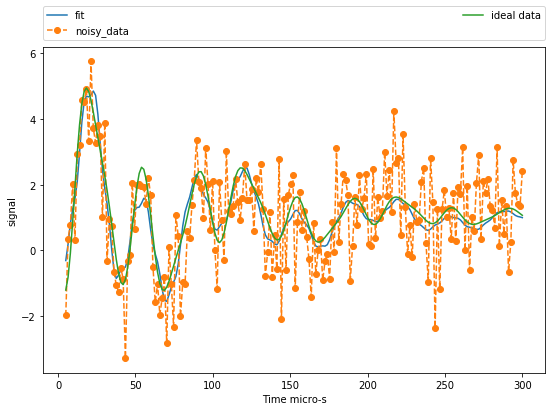

In [13]:
three_sine_exp_decay_offset_testing()

In [14]:
def three_sine_exp_decay_offset_testing2():
    """ Testing procedure for the implemented three sine with exponential
        decay and offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 2
    freq3 = 0.05

    lifetime = 100
    offset = 1.1

    data = (
        ampl1 * np.sin(2*np.pi*freq1*x_axis + phase1)
        + ampl2 * np.sin(2*np.pi*freq2*x_axis + phase2)
        + ampl3 * np.sin(2*np.pi*freq3*x_axis + phase3))*np.exp(-(x_axis/lifetime)) + offset

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*1

    result = fitlogic.make_sinetriplewithexpdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sinetriplewithexpdecay)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((((Model(amplitude_function, prefix='s1_') * Model(bare_sine_function, prefix='s1_')) + (Model(amplitude_function, prefix='s2_') * Model(bare_sine_function, prefix='s2_'))) + (Model(amplitude_function, prefix='s3_') * Model(bare_sine_function, prefix='s3_'))) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 200
    # variables        = 11
    chi-square         = 178.290
    reduced chi-square = 0.943
    Akaike info crit   = -0.982
    Bayesian info crit = 35.300
[[Variables]]
    s1_amplitude:   3.36962120 +/- 0.366457 (10.88%) (init= 2.882826)
    s1_frequency:   0.03024149 +/- 0.000297 (0.98%) (init= 0.02982053)
    s1_phase:       0.02119520 +/- 0.137920 (650.72%) (init= 0.2465624)
    s2_amplitude:   2.32585420 +/- 0.326134 (14.02%) (init= 2.379362)
    s2_frequency:   0.05063439 +/- 0.000410 (0.81%) (init= 0.05055009)
    s2_phase:       0.89749100 +/- 0.181277 (20

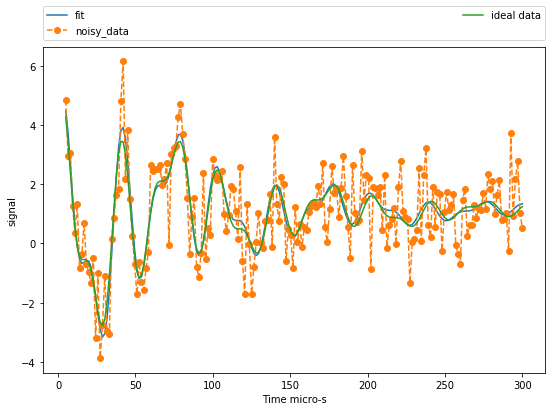

In [15]:
three_sine_exp_decay_offset_testing2()

In [16]:

def three_sine_three_exp_decay_offset_testing():
    """ Testing procedure for the estimator for a three sine with three
        exponential decays and with offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 1
    freq3 = 0.05

    lifetime1 = 100
    lifetime2 = 150
    lifetime3 = 200
    offset = 1.1

    data = ( ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1) * np.exp(-(x_axis/lifetime1))
           + ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2) * np.exp(-(x_axis/lifetime2))
           + ampl3 * np.sin(2*np.pi*freq3*x_axis +phase3) * np.exp(-(x_axis/lifetime3))
           + offset)

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*1

    x_dft1, y_dft1 = compute_dft(x_val=x_axis, y_val=noisy_data, zeropad_num=1)

    plt.figure()
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time (micro-s)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    res1 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    data_sub1 = noisy_data - res1.best_fit
    x_dft2, y_dft2 = compute_dft(x_val=x_axis, y_val=data_sub1, zeropad_num=1)
    res2 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub1,
        estimator=fitlogic.estimate_sineexponentialdecay)
    
    data_sub2 = data_sub1 - res2.best_fit
    res3 = fitlogic.make_sineexponentialdecay_fit(
        x_axis=x_axis,
        data=data_sub2,
        estimator=fitlogic.estimate_sineexponentialdecay)

    x_dft3, y_dft3 = compute_dft(x_val=x_axis, y_val=data_sub2, zeropad_num=1)

    plt.figure()
    plt.plot(x_dft1, y_dft1, '-', label='noisy_data (3 peaks)')
    plt.plot(x_dft2, y_dft2, '-', label='noisy_data (2 peaks)')
    plt.plot(x_dft3, y_dft3, '-', label='noisy_data (1 peak)')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    mod, params = fitlogic.make_sinetriplewiththreeexpdecay_model()

    params['e1_amplitude'].set(value=res1.params['amplitude'].value)
    params['e1_frequency'].set(value=res1.params['frequency'].value)
    params['e1_phase'].set(value=res1.params['phase'].value)
    params['e1_lifetime'].set(value=res1.params['lifetime'].value,
                              min=2*(x_axis[1]-x_axis[0]))

    params['e2_amplitude'].set(value=res2.params['amplitude'].value)
    params['e2_frequency'].set(value=res2.params['frequency'].value)
    params['e2_phase'].set(value=res2.params['phase'].value)
    params['e2_lifetime'].set(value=res2.params['lifetime'].value,
                              min=2*(x_axis[1]-x_axis[0]))

    params['e3_amplitude'].set(value=res3.params['amplitude'].value)
    params['e3_frequency'].set(value=res3.params['frequency'].value)
    params['e3_phase'].set(value=res3.params['phase'].value)
    params['e3_lifetime'].set(value=res3.params['lifetime'].value,
                              min=2*(x_axis[1]-x_axis[0]))

    params['offset'].set(value=data.mean())

    result = mod.fit(noisy_data, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((((Model(amplitude_function, prefix='e1_') * Model(bare_sine_function, prefix='e1_')) * Model(barestretchedexponentialdecay_function, prefix='e1_')) + ((Model(amplitude_function, prefix='e2_') * Model(bare_sine_function, prefix='e2_')) * Model(barestretchedexponentialdecay_function, prefix='e2_'))) + ((Model(amplitude_function, prefix='e3_') * Model(bare_sine_function, prefix='e3_')) * Model(barestretchedexponentialdecay_function, prefix='e3_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 87
    # data points      = 200
    # variables        = 13
    chi-square         = 180.391
    reduced chi-square = 0.965
    Akaike info crit   = 5.362
    Bayesian info crit = 48.240
[[Variables]]
    e1_amplitude:   2.32203571 +/- 0.353089 (15.21%) (init= 1.660163)
    e1_frequency:   0.00992094 +/- 0.000192 (1.93%) (init= 0.009467933)
    e1_phase:       2.24617427 +/- 0.125678 (5.60%) (init= 2.692072)
    e1_beta:        1 (fixed)
    e1_lifetime:   

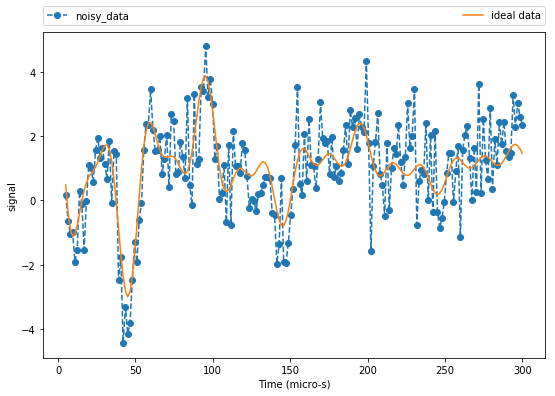

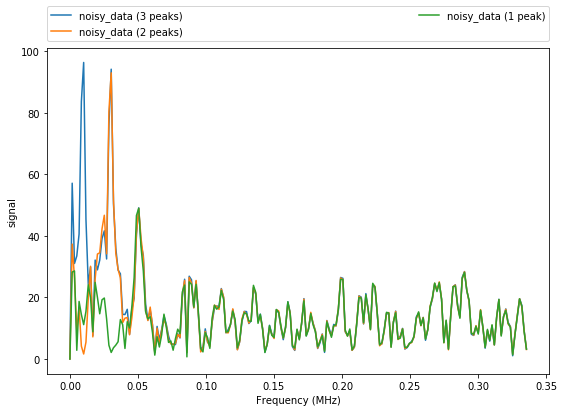

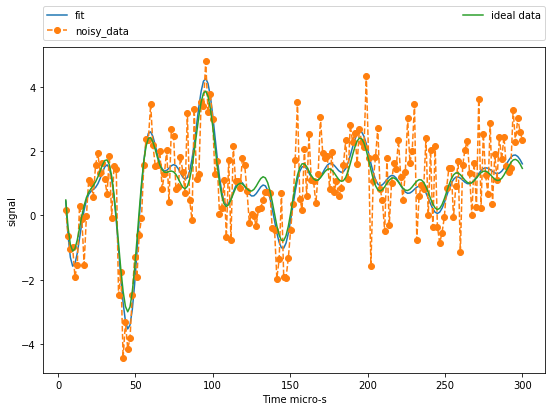

In [17]:
three_sine_three_exp_decay_offset_testing()

In [18]:
def three_sine_three_exp_decay_offset_testing2():
    """ Testing procedure for the implemented three sine with three
        exponential decay and offset fit. """

    x_axis = np.linspace(5, 300 ,200)

    phase1 = np.random.uniform()*2*np.pi
    ampl1 = 3
    freq1 = 0.03

    phase2 = np.random.uniform()*2*np.pi
    ampl2 = 2
    freq2 = 0.01

    phase3 = np.random.uniform()*2*np.pi
    ampl3 = 1
    freq3 = 0.05

    lifetime1 = 120
    lifetime2 = 150
    lifetime3 = 50
    offset = 1.1

    data = ( ampl1 * np.sin(2*np.pi*freq1*x_axis +phase1) * np.exp(-(x_axis/lifetime1))
           + ampl2 * np.sin(2*np.pi*freq2*x_axis +phase2) * np.exp(-(x_axis/lifetime2))
           + ampl3 * np.sin(2*np.pi*freq3*x_axis +phase3) * np.exp(-(x_axis/lifetime3))
           + offset)

    noisy_data = data + data.mean() * np.random.normal(size=x_axis.shape)*1.2

    result = fitlogic.make_sinetriplewiththreeexpdecay_fit(
        x_axis=x_axis,
        data=noisy_data,
        estimator=fitlogic.estimate_sinetriplewiththreeexpdecay)

    plt.figure()
    plt.plot(x_axis, result.best_fit,'-', label='fit')
    plt.plot(x_axis, noisy_data, 'o--', label='noisy_data')
    plt.plot(x_axis, data,'-', label='ideal data')
    plt.xlabel('Time micro-s')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((((Model(amplitude_function, prefix='e1_') * Model(bare_sine_function, prefix='e1_')) * Model(barestretchedexponentialdecay_function, prefix='e1_')) + ((Model(amplitude_function, prefix='e2_') * Model(bare_sine_function, prefix='e2_')) * Model(barestretchedexponentialdecay_function, prefix='e2_'))) + ((Model(amplitude_function, prefix='e3_') * Model(bare_sine_function, prefix='e3_')) * Model(barestretchedexponentialdecay_function, prefix='e3_'))) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 87
    # data points      = 200
    # variables        = 13
    chi-square         = 341.361
    reduced chi-square = 1.825
    Akaike info crit   = 132.925
    Bayesian info crit = 175.803
[[Variables]]
    e1_amplitude:   2.57967133 +/- 0.456949 (17.71%) (init= 3.914832)
    e1_frequency:   0.00997084 +/- 0.000282 (2.83%) (init= 0.009882487)
    e1_phase:       1.23336410 +/- 0.183593 (14.89%) (init= 1.302451)
    e1_beta:        1 (fixed)
    e1_lifetime

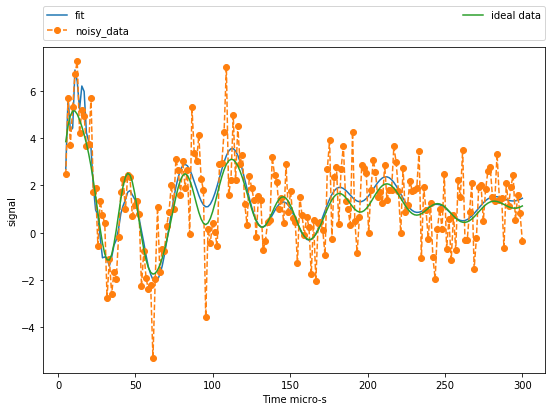

In [19]:
three_sine_three_exp_decay_offset_testing2()